In [16]:
import deltascope as ds
import deltascope.alignment as ut
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize, Normalizer
from scipy.optimize import minimize
from scipy.stats import normaltest

import os
import tqdm
import json
import time

# Import raw data
The user needs to specify the directories containing the data of interest. Each sample type should have a key which corresponds to the directory path. Additionally, each object should have a list that includes the channels of interest.

In [17]:
# --------------------------------
# -------- User input ------------
# --------------------------------

data = {
    # Specify sample type key
    'wt': {
        # Specify path to data directory
        'path': './../yot_experiment/data/Output_wt03-31-17-48',
        # Specify which channels are in the directory and are of interest
        'channels': ['AT','ZRF']
    },
    'yot': {
        'path': './../yot_experiment/data/Output_yot03-31-17-48',
        'channels': ['AT','ZRF']
    },
    'hss1a': {
        'path': './data/hss1a/Output-02-15-2019',
        'channels': ['AT','ZRF']
    },
    'hss1ayot': {
        'path': './data/hss1ayot/Output-02-15-2019',
        'channels': ['AT','ZRF']
    }
}

In [18]:
data_pairs = []
for s in data.keys():
    for c in data[s]['channels']:
        data_pairs.append((s,c))

We can now read in all datafiles specified by the `data` dictionary above.

In [19]:
D = {}
for s in data.keys():
    D[s] = {}
    for c in data[s]['channels']:
        D[s][c] = ds.read_psi_to_dict(data[s]['path'],c)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 37.86it/s]


Display the numer of samples for each sample type.

In [20]:
len(D['wt']['AT'].keys()),len(D['yot']['AT'].keys()),len(D['hss1a']['AT'].keys()),len(D['hss1ayot']['AT'].keys())

(37, 33, 10, 17)

# Landmarks

Calculate landmark bins based on user input parameters and the previously specified control sample.

In [21]:
# --------------------------------
# -------- User input ------------
# --------------------------------

# Specify stype to use as control
s_ctrl = 'wt'
# Specify channel to use as control
c_ctrl = 'AT'

# Specify size of theta bins
theta_step = np.pi/4
# Specify the step size when sweeping various alpha bin sizes
astep = 3
# Specify minimum a value 
amn = 2
# Specify maximum a value
amx = 50

In [22]:
optr = ds.anumSelect(D[s_ctrl][c_ctrl])
optr.param_sweep(theta_step, amn=amn, amx=amx, astep=astep,
                 rnull=np.nan, DT='r')

2 calculation complete
5 calculation complete
8 calculation complete
11 calculation complete
14 calculation complete
17 calculation complete
20 calculation complete
23 calculation complete
26 calculation complete
29 calculation complete
32 calculation complete
35 calculation complete
38 calculation complete
41 calculation complete
44 calculation complete
47 calculation complete
Parameter sweep complete


In [23]:
# --------------------------------
# -------- User input ------------
# --------------------------------

# Select degrees of freedom for curve fitting
dof = 5

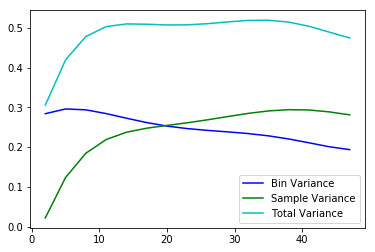

In [25]:
x = np.arange(amn,amx,astep)
fig,ax = plt.subplots()

# Fit a curve to bin variance values
optrMbvarray = np.array(optr.Mbv).reshape(1, len(optr.Mbv))
pbv = np.polyfit(x, normalize(optrMbvarray)[0], dof)
fbv = np.poly1d(pbv)
ax.plot(x, fbv(x), c='b', label='Bin Variance')

# Fit curve to sample variance values
optrMsvarray = np.array(optr.Msv).reshape(1, len(optr.Msv))
psv = np.polyfit(x, normalize(optrMsvarray)[0], dof)
fsv = np.poly1d(psv)
ax.plot(x, fsv(x), c='g', label='Sample Variance')

# Plot sum of sample and bin variances
ax.plot(x, fsv(x)+fbv(x), c='c', label='Total Variance')

ax.legend()
tstamp = datetime.datetime.now().strftime('%Y-%m-%d')
location = "C:\\Users\\zfishlab\\Code\\deltascope\\figures\\Raw_Figures_for_DeltaScope_revision\\"
fig.savefig(location+tstamp+'_slit1alandmarkoptimization-{}-{}.png'.format(c_ctrl,s_ctrl))

In [11]:

# --------------------------------
# -------- User input ------------
# --------------------------------

# Guess the approximate optimal value
guess = 25

In [12]:
opt = minimize(fbv+fsv, guess)
ax.axvline(opt.x, c='r', label='Optimum: '+str(np.round(opt.x[0], 2)))
print(opt.x[0])

21.204086054876004


In [13]:
# --------------------------------
# -------- User input ------------
# --------------------------------

# Pick an integer value for bin number based on results above
anum = 21

# Specify the percentiles which will be used to calculate landmarks
percbins = [50]

theta_step = np.pi/4

s_ctrl = 'wt'
c_ctrl = 'AT'

In [14]:
lm = ds.landmarks(percbins=percbins, rnull=np.nan)
lm.calc_bins(D[s_ctrl][c_ctrl], anum, theta_step)

print('Alpha bins')
print(lm.acbins)
print('Theta bins')
print(lm.tbins)

Alpha bins
[-83.53412655 -75.18071389 -66.82730124 -58.47388858 -50.12047593
 -41.76706327 -33.41365062 -25.06023796 -16.70682531  -8.35341265
   0.           8.35341265  16.70682531  25.06023796  33.41365062
  41.76706327  50.12047593  58.47388858  66.82730124  75.18071389
  83.53412655]
Theta bins
[-3.14159265 -2.35619449 -1.57079633 -0.78539816  0.          0.78539816
  1.57079633  2.35619449  3.14159265]


In [15]:
lmdf = pd.DataFrame()

# Loop through each pair of stype and channels
for s,c in tqdm.tqdm(data_pairs):
    print(s,c)
    # Calculate landmarks for each sample with this data pair
    for k,df in tqdm.tqdm(D[s][c].items()):
        lmdf = lm.calc_perc(df, k, '-'.join([s,c]), lmdf)
        
# Set timestamp for saving data
tstamp = time.strftime("%m-%d-%H-%M",time.localtime())
        
# Save completed landmarks to a csv file
lmdf.to_csv(tstamp+'_landmarks.csv')

# Save landmark bins to json file
bins = {
    'acbins':list(lm.acbins),
    'tbins':list(lm.tbins)
}
with open(tstamp+'_landmarks_bins.json', 'w') as outfile:
    json.dump(bins, outfile)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

wt AT



 12%|██████████▌                                                                         | 1/8 [00:45<05:19, 45.66s/it]

wt ZRF



 25%|█████████████████████                                                               | 2/8 [01:24<04:22, 43.76s/it]

yot AT



 38%|███████████████████████████████▌                                                    | 3/8 [01:48<03:08, 37.76s/it]

yot ZRF



 50%|██████████████████████████████████████████                                          | 4/8 [02:16<02:18, 34.73s/it]

hss1a AT



 62%|████████████████████████████████████████████████████▌                               | 5/8 [02:22<01:18, 26.13s/it]

hss1a ZRF



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:28<00:40, 20.20s/it]

hss1ayot AT



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [02:38<00:16, 16.90s/it]

hss1ayot ZRF



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:48<00:00, 14.83s/it]
